In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

import os
import json
import xmitgcm as xm

In [6]:
particle_folders =[r"~//parcels_toolbox//02_output//artful_01_diff.zarr",
                  r"~//parcels_toolbox//02_output//artful_02_diff.zarr",
                  r"~//parcels_toolbox//02_output//artful_03_diff.zarr",
                  r"~//parcels_toolbox//02_output//artful_02_backward.zarr"]

plot_dates = [np.datetime64('2023-09-12 12:00:00'),
              np.datetime64('2023-11-08 11:00:00'),
              np.datetime64('2024-05-01 10:00:00'),
              np.datetime64('2023-11-08 11:00:00')]

measure_file_paths = [ r"..//coord_sampling//measures_20230912.txt",
                       r"..//coord_sampling//measures_20231108.txt",
                       r"..//coord_sampling//measures_20240501.txt",
                       r"..//coord_sampling//measures_20231108.txt"]

In [22]:
i_scenario = 3
i_artful = 2
period_seeding = np.timedelta64(10, 'D')
measure_file_path = measure_file_paths[i_scenario]

### Get location of measure points

In [8]:
meas_coordinates = pd.read_csv(measure_file_path, delimiter=';', dtype=None, names=["x", "y", "label"], encoding='utf-8')

### Import particles results

In [9]:
xr_particules = xr.open_zarr(particle_folders[i_scenario]) # obs= time index (0=the moment the particule is seeded), trajectory= particle

In [10]:
arr_time = xr_particules.time.values.flatten()
df_time = pd.Series(arr_time)
df_time = df_time.dropna().drop_duplicates().reset_index(drop=True)

In [11]:
xr_particules['age'] = (xr_particules['time'] - xr_particules['time'].isel(obs=0)).dt.total_seconds() / 86400

In [12]:
df_time

0     2023-11-08 11:00:00
1     2023-11-08 10:00:00
2     2023-11-08 09:00:00
3     2023-11-08 08:00:00
4     2023-11-08 07:00:00
              ...        
239   2023-10-29 12:00:00
240   2023-10-29 11:00:00
241   2023-10-29 10:00:00
242   2023-10-29 09:00:00
243   2023-10-29 08:00:00
Length: 244, dtype: datetime64[ns]

### Filter particle per launching date

In [13]:
plot_date = np.datetime64(plot_dates[i_scenario])
date_start_seeding = plot_date - period_seeding

t_ini = xr_particules.isel(obs=0)['time'].values
pid = xr_particules['trajectory'].values

mask = (t_ini >= np.datetime64(date_start_seeding)) & (t_ini <= np.datetime64(plot_date))
filtered_pid = pid[mask]
filtered_particles = xr_particules.sel(trajectory=filtered_pid)

In [14]:
filtered_pid

array([6000, 6001, 6002, ..., 7997, 7998, 7999])

### Plot snapshot

In [16]:
filtered_particles.time.values[0]

array(['2023-11-08T11:00:00.000000000', '2023-11-08T10:00:00.000000000',
       '2023-11-08T09:00:00.000000000', '2023-11-08T08:00:00.000000000',
       '2023-11-08T07:00:00.000000000', '2023-11-08T06:00:00.000000000',
       '2023-11-08T05:00:00.000000000', '2023-11-08T04:00:00.000000000',
       '2023-11-08T03:00:00.000000000', '2023-11-08T02:00:00.000000000',
       '2023-11-08T01:00:00.000000000', '2023-11-08T00:00:00.000000000',
       '2023-11-07T23:00:00.000000000', '2023-11-07T22:00:00.000000000',
       '2023-11-07T21:00:00.000000000', '2023-11-07T20:00:00.000000000',
       '2023-11-07T19:00:00.000000000', '2023-11-07T18:00:00.000000000',
       '2023-11-07T17:00:00.000000000', '2023-11-07T16:00:00.000000000',
       '2023-11-07T15:00:00.000000000', '2023-11-07T14:00:00.000000000',
       '2023-11-07T13:00:00.000000000', '2023-11-07T12:00:00.000000000',
       '2023-11-07T11:00:00.000000000', '2023-11-07T10:00:00.000000000',
       '2023-11-07T09:00:00.000000000', '2023-11-07

In [17]:
i_snapshot = 240
snapshot = filtered_particles.where(filtered_particles['time']==np.datetime64(df_time[i_snapshot]))

In [18]:
mask_snapshot = ~np.isnan(snapshot.lon.values)

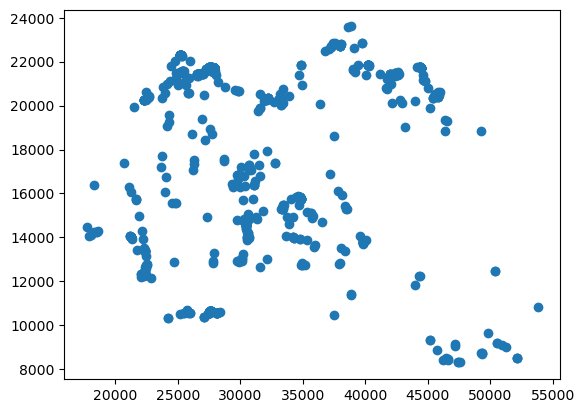

In [19]:
plt.scatter(snapshot.lon.values[mask_snapshot], snapshot.lat.values[mask_snapshot])
plt.show()

### Check particles trajectories

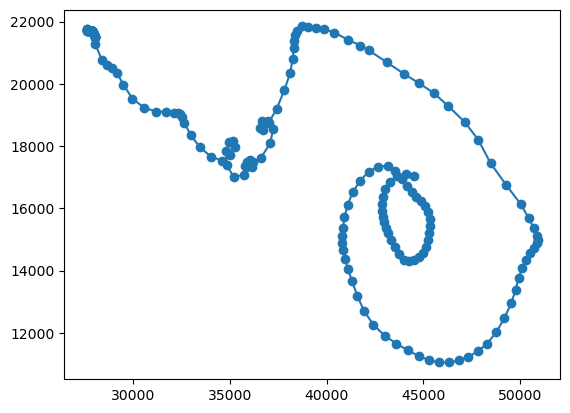

In [20]:
part_traj = xr_particules.isel(trajectory=0)
plt.plot(part_traj["lon"].T, part_traj["lat"].T, marker="o")

### Import MITgcm results

In [23]:
model = f'geneva_artful_0{i_artful}'
with open('..//config.json', 'r') as file:
    config_plots = json.load(file)[os.uname().nodename][model]

xr_mitgcm=xr.open_dataset(config_plots['nc_path'])

In [24]:
mask_mitgcm = xr_mitgcm['THETA'].isel(time=0, Z=0).values > 0

In [25]:
xr_mitgcm.Z.isel(Z=30)

<xarray.DataArray 'Z' ()> Size: 4B
array(-24.7055, dtype=float32)
Coordinates:
    Z        float32 4B -24.71
    drF      float32 4B ...
    PHrefC   float32 4B ...
    rhoRef   float32 4B ...
Attributes:
    standard_name:  depth
    long_name:      vertical coordinate of cell center
    units:          m
    positive:       down
    axis:           Z

### Plot everything together

In [26]:
date_start = xr_particules.time.values[0,0]
z_start = xr_particules['z'].values[0,0]

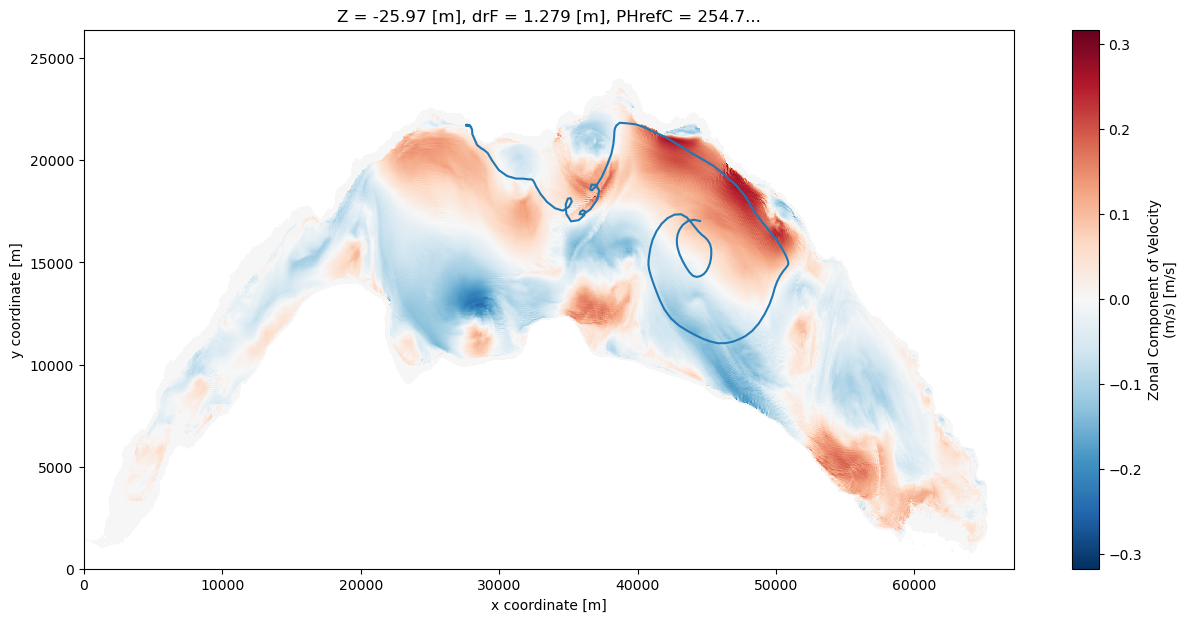

In [33]:
plt.figure(figsize=(15,7))
xr_mitgcm['UVEL'].sel(time=date_start, Z=z_start, method='nearest').where(mask_mitgcm).plot();
part_traj = xr_particules.isel(trajectory=0)
plt.plot(part_traj["lon"].T, part_traj["lat"].T);
#plt.ylim(bottom=19500, top=22500)
#plt.xlim(left=40000, right=46000)
#plt.savefig('./output/whole_lake_particles_traj')

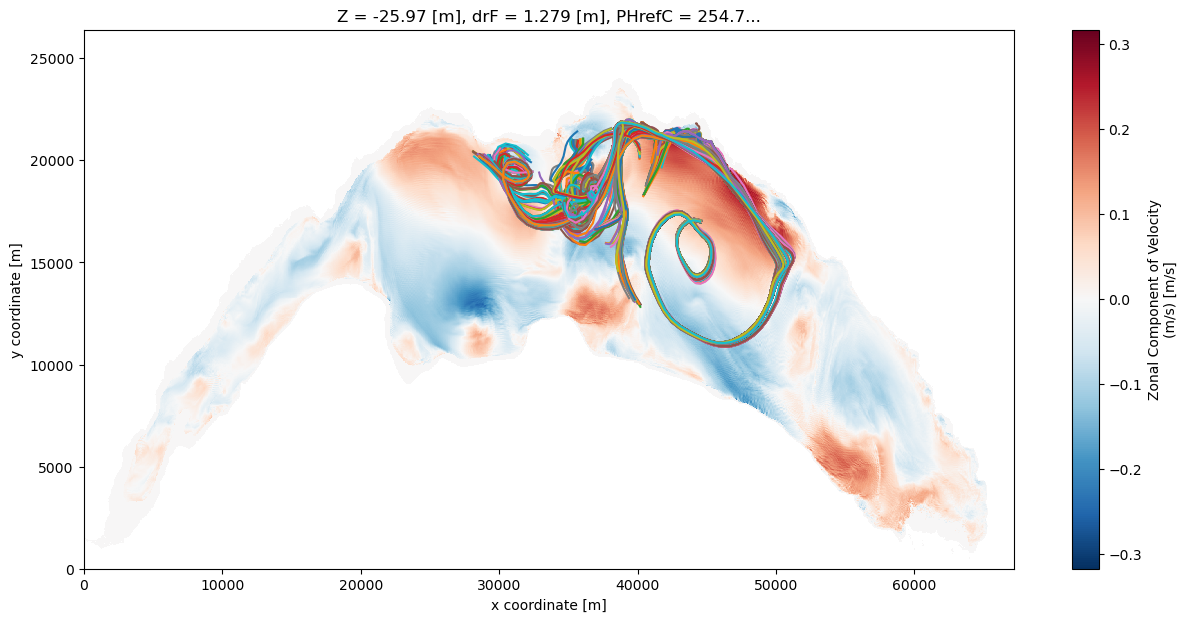

In [50]:
plt.figure(figsize=(15,7))
xr_mitgcm['UVEL'].sel(time=date_start, Z=z_start, method='nearest').where(mask_mitgcm).plot();
sel_part = xr_particules.where(-1 * xr_particules['age'] < 5)
plt.plot(sel_part["lon"].T, sel_part["lat"].T);
#plt.ylim(bottom=19500, top=22500)
#plt.xlim(left=40000, right=46000)
#plt.savefig('./output/whole_lake_particles_traj')

In [28]:
df_time[i_snapshot]

Timestamp('2023-10-29 11:00:00')

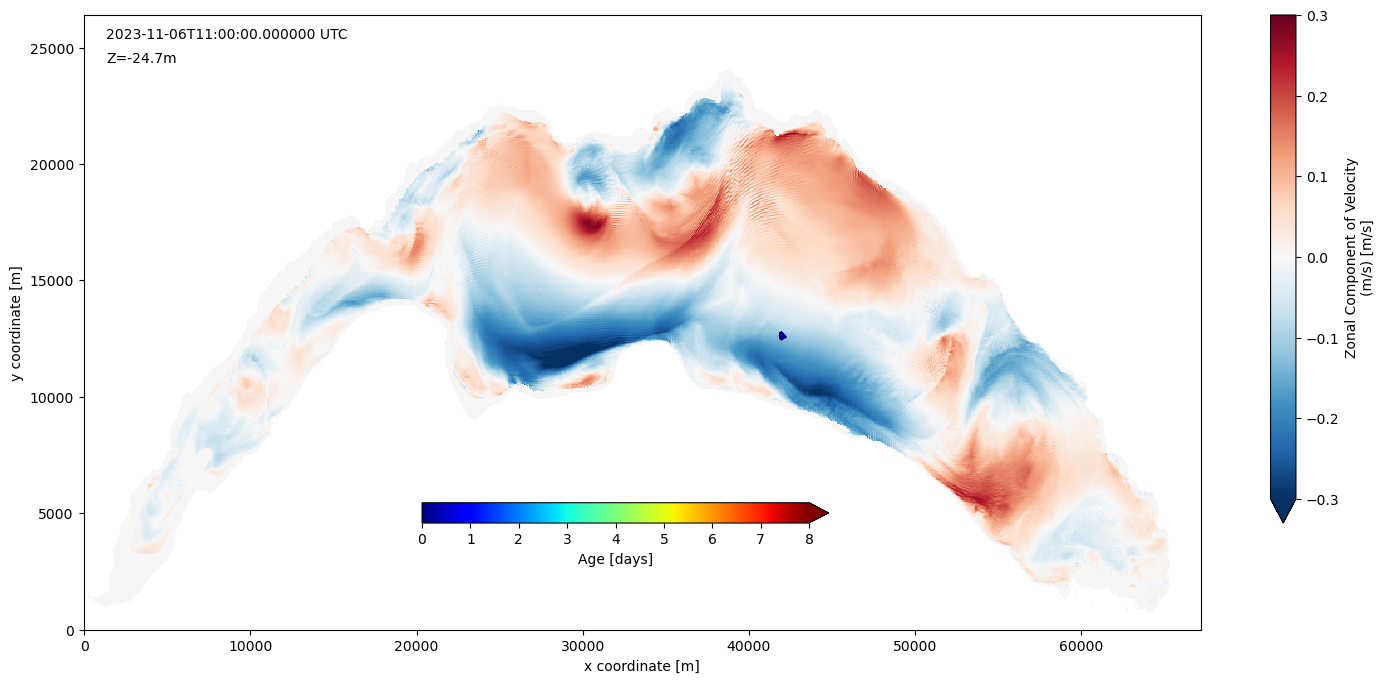

In [32]:
plt.figure(figsize=(15,7))
i_snapshot = 48
i_z = 30

date_plot=np.datetime64(df_time[i_snapshot])
snapshot = filtered_particles.where(filtered_particles['time']==date_plot)
mask_snapshot = ~np.isnan(snapshot.lon.values)

xr_mitgcm['UVEL'].isel(Z=i_z).sel(time=date_plot, method='nearest').where(mask_mitgcm).plot(vmin=-0.3, vmax=0.3, cmap='RdBu_r')
scatter = plt.scatter(snapshot["lon"].values[mask_snapshot], snapshot["lat"].values[mask_snapshot], 
                      c=snapshot["age"].values[mask_snapshot], cmap='jet', s=2, vmin=0, vmax=8)

# Add colorbar for 'age'
cbar = plt.colorbar(scatter, ax=plt.gca(), fraction=0.04, orientation="horizontal", pad=-0.25, extend='max')
cbar.set_label('Age [days]')

#plt.ylim(bottom=20500, top=22500)
#plt.xlim(left=40000, right=56000)
plt.text(0.02, 0.98, f'{date_plot} UTC', transform=plt.gca().transAxes, ha='left', va='top')
plt.text(0.02, 0.94, f'Z={str(xr_mitgcm.Z.isel(Z=i_z).values.round(1))}m', transform=plt.gca().transAxes, ha='left', va='top')
plt.title('')
plt.tight_layout()
plt.show()

In [129]:
def plot_quiver(ds_to_plot, date_plot, i_depth: int, scale: int = 10, subsetting_factor: int = 20):

    X_trimmed = ds_to_plot['XC'][::subsetting_factor]
    Y_trimmed = ds_to_plot['YC'][::subsetting_factor]
    U_trimmed = ds_to_plot['UVEL'].isel(Z=i_depth).sel(time=date_plot, method='nearest')[:,1:][::subsetting_factor,::subsetting_factor]
    V_trimmed = ds_to_plot['VVEL'].isel(Z=i_depth).sel(time=date_plot, method='nearest')[1:,:][::subsetting_factor,::subsetting_factor]
    
    U_trimmed = U_trimmed.where(U_trimmed != 0, np.nan)
    V_trimmed = V_trimmed.where(V_trimmed != 0, np.nan)
    plt.quiver(X_trimmed, Y_trimmed, U_trimmed, V_trimmed, scale=scale)
    
    return plt.gcf()

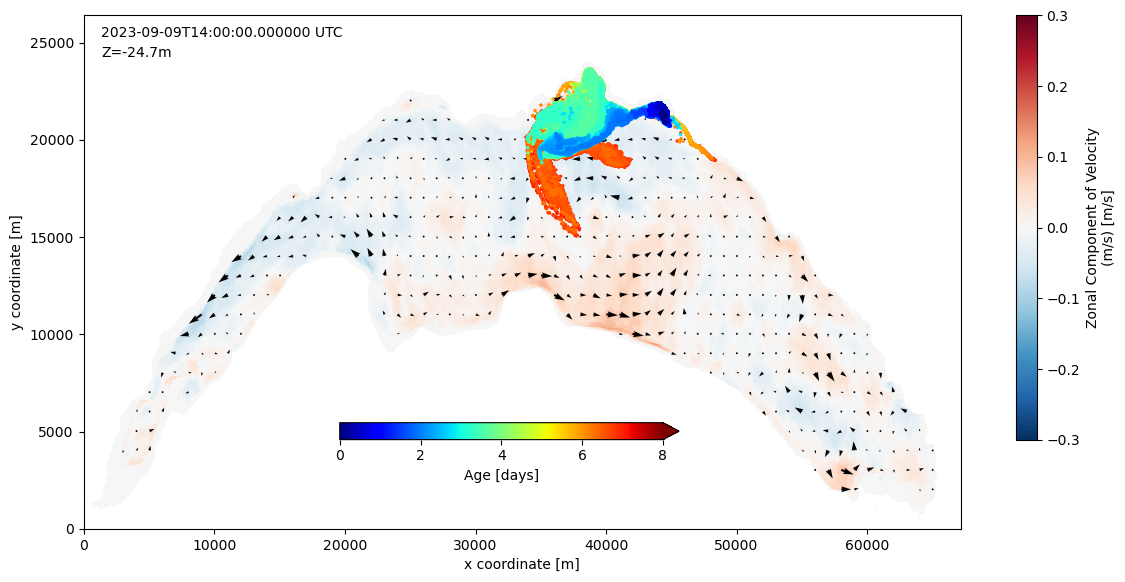

In [130]:
plt.figure(figsize=(12,6))
i_snapshot = 170
i_z = 30

date_plot=np.datetime64(df_time[i_snapshot])
snapshot = xr_particules.where(xr_particules['time']==date_plot)
mask_snapshot = ~np.isnan(snapshot.lon.values)

xr_mitgcm['UVEL'].isel(Z=i_z).sel(time=date_plot, method='nearest').where(mask_mitgcm).plot(vmin=-0.3, vmax=0.3, cmap='RdBu_r')
plot_quiver(xr_mitgcm, date_plot, i_z, scale=6, subsetting_factor=20)
scatter = plt.scatter(snapshot["lon"].values[mask_snapshot], snapshot["lat"].values[mask_snapshot], 
                      c=snapshot["age"].values[mask_snapshot], cmap='jet', s=2, vmin=0, vmax=8)

# Add colorbar for 'age'
cbar = plt.colorbar(scatter, ax=plt.gca(), fraction=0.04, orientation="horizontal", pad=-0.25, extend='max')
cbar.set_label('Age [days]')

#plt.ylim(bottom=20500, top=22500)
#plt.xlim(left=40000, right=56000)
plt.text(0.02, 0.98, f'{date_plot} UTC', transform=plt.gca().transAxes, ha='left', va='top')
plt.text(0.02, 0.94, f'Z={str(xr_mitgcm.Z.isel(Z=i_z).values.round(1))}m', transform=plt.gca().transAxes, ha='left', va='top')
plt.title('')
plt.tight_layout()
plt.show()

### Loop plot

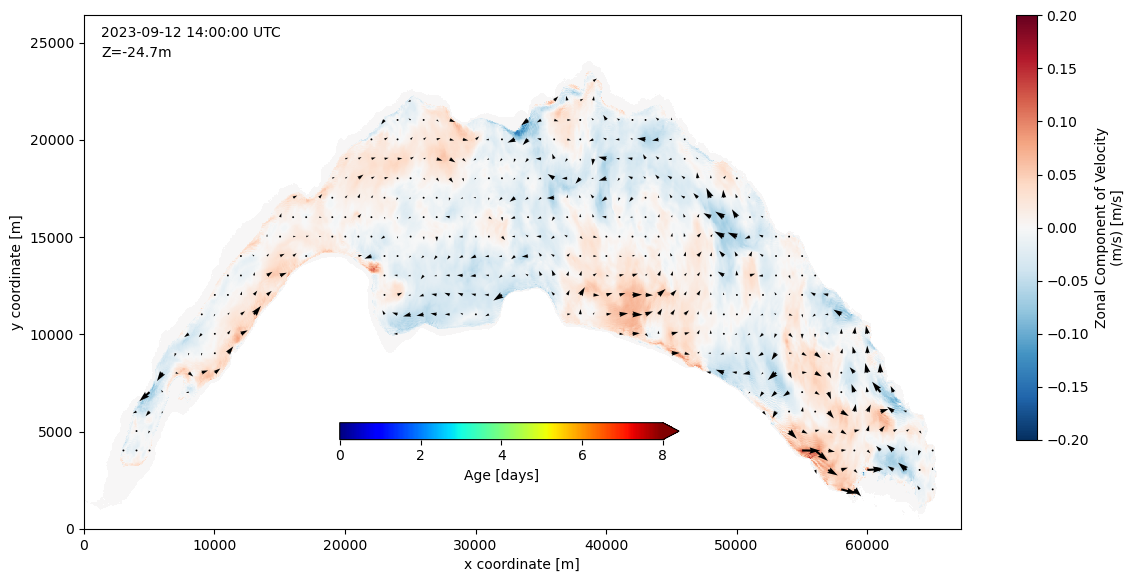

In [131]:
i_z=30
start_index = df_time[df_time == np.datetime64(date_start_seeding)].index.item()
for i_snapshot in range(start_index, len(df_time)-1):
    plt.close('all')
    plt.figure(figsize=(12,6))
    
    date_plot=df_time[i_snapshot]
    snapshot = filtered_particles.where(filtered_particles['time']==date_plot)
    mask_snapshot = ~np.isnan(snapshot.lon.values)
    
    xr_mitgcm['UVEL'].isel(Z=i_z).sel(time=date_plot, method='nearest').where(mask_mitgcm).plot(vmin=-0.2, vmax=0.2, cmap='RdBu_r')
    plot_quiver(xr_mitgcm, date_plot, i_z, scale=6, subsetting_factor=20)
    scatter = plt.scatter(snapshot["lon"].values[mask_snapshot], snapshot["lat"].values[mask_snapshot], 
                          c=filtered_particles["age"].values[mask_snapshot], cmap='jet', s=2, vmin=0, vmax=8)
    
    # Add colorbar for 'age'
    cbar = plt.colorbar(scatter, ax=plt.gca(), fraction=0.04, orientation="horizontal", pad=-0.25, extend='max')
    cbar.set_label('Age [days]')
    
    plt.text(0.02, 0.98, f'{date_plot} UTC', transform=plt.gca().transAxes, ha='left', va='top')
    plt.text(0.02, 0.94, f'Z={str(xr_mitgcm.Z.isel(Z=i_z).values.round(1))}m', transform=plt.gca().transAxes, ha='left', va='top')
    plt.title('')
    plt.tight_layout()
    plt.savefig(f'./figures/artful01_diff/artful01_{str(i_snapshot).zfill(3)}')